In [86]:
import PyPDF2
import nltk
import spacy
#nltk.download('stopwords')
from nltk.corpus import stopwords, wordnet
import string
import re
import matplotlib.pyplot as plt

In [93]:
# define the class
class EarningsAnalysis:
    def __init__(self, company_name, quarter):
        # Validate company name
        if not company_name.islower():
            raise ValueError("Company name should be in lowercase.")
        self.company_name = company_name

        # Validate quarter format
        quarter_pattern = r"^Q[1-4]\d{2}$"
        if not re.match(quarter_pattern, quarter):
            raise ValueError("Quarter should be in the format Q[1,2,3,4]YY.")
        self.quarter = quarter

    def extract_text_from_pdf(self, pdf_path: str):
        """
        This method extracts text from a PDF doc into a single stream of text.
        """
        text = ""
        with open(pdf_path, "rb") as pdf_file:
            pdf_reader = PyPDF2.PdfReader(pdf_file)
            for page_num in range(len(pdf_reader.pages)):
                page = pdf_reader.pages[page_num]
                text += page.extract_text()
        return text

    def preprocess_words(self, text: str):
        """
        This method breaks down the pdf text into tokens of words.
        """
        singles_removed = re.sub(r'\s+[a-zA-Z]\s', ' ', text)
        tokens = nltk.word_tokenize(singles_removed)
        clean_tokens = [token.lower() for token in tokens if token.isalnum()]
        stop_all = stopwords.words('english') + list(string.punctuation)
        stop_removal = [stop for stop in clean_tokens if stop not in stop_all]
        pos_tokens = nltk.pos_tag(stop_removal)

        lemmatizer = nltk.WordNetLemmatizer()
        stems = []
        for t in pos_tokens:
            word = t[0]
            pos_type = t[1]
            wordnet_pos = self.get_wordnet_pos(pos_type)
            stems.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
        return stop_removal, stems, pos_tokens

    def extract_keywords(self, tokens: list, num_ngrams: int):
        """
        This method extracts relevant keywords using n-grams.
        """
        ngrams = nltk.ngrams(tokens, num_ngrams)
        ngram_freq = nltk.FreqDist(ngrams)
        
        stopwords_custom = ["company_name", "financial_term", "common_jargon"]  # Define domain-specific stopwords
        
        keywords = [ngram for ngram in ngram_freq if ngram[0] not in stopwords_custom and ngram[1] not in stopwords_custom]
        return keywords, ngram_freq

    def get_wordnet_pos(self, treebank_tag):
        if treebank_tag.startswith('J'):
            return wordnet.ADJ
        elif treebank_tag.startswith('V'):
            return wordnet.VERB
        elif treebank_tag.startswith('N'):
            return wordnet.NOUN
        elif treebank_tag.startswith('R'):
            return wordnet.ADV
        else:
            return wordnet.NOUN  # Default to noun if POS tag is not recognized

    def word_frequency_dist(self, tokens: list):
        fdist = nltk.FreqDist(tokens)
        fdist.plot(30, cumulative=False, title="Top 30 Most Common Words")

    def preprocess_sentences(self, text: str):
        """
        This method breaks down the pdf text into tokens of sentences which is 
        more useful for later methods to provide context about topics discussed in the call.
        """
        #singles_removed = re.sub(r'\s+[a-zA-Z]\s', ' ', text)
        tokens = nltk.sent_tokenize(text)
        clean_tokens = [token.lower() for token in tokens if token.isalnum()]
        stop_all = stopwords.words('english') + list(string.punctuation)
        stop_removal = [stop for stop in clean_tokens if stop not in stop_all]
        pos_tokens = nltk.pos_tag(stop_removal)

        lemmatizer = nltk.WordNetLemmatizer()
        stems = []
        for t in pos_tokens:
            word = t[0]
            pos_type = t[1]
            wordnet_pos = self.get_wordnet_pos(pos_type)
            stems.append(lemmatizer.lemmatize(word, pos=wordnet_pos))
        return stop_removal, stems, pos_tokens


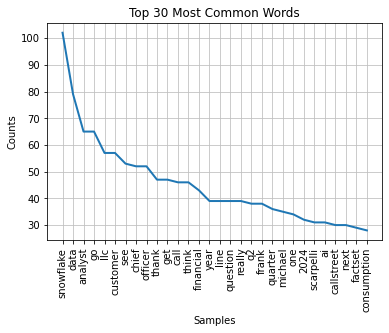

In [94]:
earnings_analysis = EarningsAnalysis()
snowflake = earnings_analysis.extract_text_from_pdf("Data/SNOW_Q224.pdf")
removed_stopwords, word_stems, pos_tags = earnings_analysis.preprocess_text(snowflake)
earnings_analysis.word_frequency_dist(word_stems)